In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import rioxarray

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

In [2]:
degrees = 2.5
da_degrees=2.5
LON = np.linspace(-180+degrees*0.5,180-degrees*0.5,int(360/degrees))
#LON[LON<0] += 360
LAT = np.linspace(-90+degrees*0.5,90-degrees*0.5,int(180/degrees))

lon_df, lat_df = np.meshgrid(LON,LAT)


ndf = (
    pd.DataFrame({"LAT": lat_df.ravel(), "LON": lon_df.ravel()})
)

ndf["LAT_25"] = ndf['LAT']//da_degrees*da_degrees+da_degrees*0.5
ndf["LON_25"] = ndf['LON']//da_degrees*da_degrees+da_degrees*0.5
ndf["LAT_5"] = ndf['LAT']//5*5+5*0.5
ndf["LON_5"] = ndf['LON']//5*5+5*0.5
ndf['order'] = list(ndf.index)

#ndf.loc[ndf['LON']>180,"LON"]-=360

ndf.head()

,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,order
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,0
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,1
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,2
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,3
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,4


In [3]:
import_data = [
    ("9cat.195101-201012.nc","knutson_precip","Original precipitation"),
    ("precip_adj_attribution_categories_g05_centred_v2.nc","updated_precip", "Updated precipitation"),
    (None, "diff_precip", "Change in attributable precipitation"),
    ("7cat.Fig.10-12.1951-2010.temp_ANN.CMIP5.nc","knutson_temp", "Original temperature"),
    ("tas_adj_attribution_categories_g05_centred_v1.nc","updated_temp", "Updated temperature"),
    (None, "diff_temp", "Change in attributable temperature")
]

for fname, cname, title in import_data:
    if fname is None:
        continue
    da_dataset = xr.open_dataset(f'../data/d_a/{fname}', decode_times=False)
        
    print(cname)
    
        
    if "knutson" in cname:
        if "precip" in cname:
            da_dataset = da_dataset.roll(LON=72, roll_coords=True)
            arr_vars = ["CP4","CP3","CP2","CP1","CP0","CM1","CM2","CM3","CM4"]
            original_values = [4,3,2,1,0,-1,-2,-3,-4]
            simplified_values = [4,3,2,1,0,-1,-2,-3,-4]
            latname = "LAT_25"
            lonname = "LON_25"
        else:
            da_dataset = da_dataset.roll(LON37_108=72, roll_coords=True)
            arr_vars = ["P3","P2","P1","P0","M1","M2","M3"]
            original_values = [3,2,1,0,-1,-2,-3]
            simplified_values = [3,2,1,0,-1,-2,-3]
            latname = "LAT_5"
            lonname = "LON_5"
            
        
        

        da_dataset = da_dataset.to_dataframe().rename(columns={"LON37_108":"LON"})
        for o_v, s_v, arr_var in zip(original_values, simplified_values, arr_vars):
            da_dataset.loc[da_dataset[arr_var].values==o_v, "da_cat"] = s_v
    else:
        da_dataset = (da_dataset
                      .to_dataframe()
                      .reset_index()
                      .rename(columns={
                          "latitude":"LAT","longitude":"LON",
                          "Attribution_Category_2016":"da_cat",
                          "Attribution_Category_2018":"da_cat"
                      })
                     )
        
    
    #da_dataset.loc[abs(da_dataset['da_cat'])==4,"da_cat"] = np.NaN
    da_dataset = da_dataset.reset_index().rename(columns={"LON37_108":"LON"})
    da_dataset.loc[da_dataset['LON']>180,"LON"]-=360
    print(da_dataset['LON'].unique())
    print(da_dataset.groupby('da_cat').count())
        
    ndf = ndf.merge(
        da_dataset
        #.reset_index()
        .rename(columns={"LAT": latname, "LON": lonname, "da_cat": cname})
        [[latname,lonname,cname]],
        how="inner",
        sort=False
    )
    
ndf = ndf.sort_values('order').drop(columns="order")

rds = rioxarray.open_rasterio("../data/d_a/gpw_v4_population_count_rev11_2020_1_deg.asc",
)

rds = rds.squeeze().drop("spatial_ref").drop("band")
rds.name = "population"
pop_df = rds.to_dataframe().reset_index()

pop_df['LAT'] = pop_df['y']//2.5*2.5+1.25
pop_df['LON'] = pop_df['x']//2.5*2.5+1.25
pop_df.loc[pop_df['population']==-9999,"population"]=np.NaN
pop_df = pop_df.groupby(["LAT","LON"])['population'].sum().reset_index()

ndf = ndf.merge(pop_df, how="left")
ndf.loc[ndf['population']==-9999,"population"]=np.NaN

ndf.head()

knutson_precip
[-178.75 -176.25 -173.75 -171.25 -168.75 -166.25 -163.75 -161.25 -158.75
 -156.25 -153.75 -151.25 -148.75 -146.25 -143.75 -141.25 -138.75 -136.25
 -133.75 -131.25 -128.75 -126.25 -123.75 -121.25 -118.75 -116.25 -113.75
 -111.25 -108.75 -106.25 -103.75 -101.25  -98.75  -96.25  -93.75  -91.25
  -88.75  -86.25  -83.75  -81.25  -78.75  -76.25  -73.75  -71.25  -68.75
  -66.25  -63.75  -61.25  -58.75  -56.25  -53.75  -51.25  -48.75  -46.25
  -43.75  -41.25  -38.75  -36.25  -33.75  -31.25  -28.75  -26.25  -23.75
  -21.25  -18.75  -16.25  -13.75  -11.25   -8.75   -6.25   -3.75   -1.25
    1.25    3.75    6.25    8.75   11.25   13.75   16.25   18.75   21.25
   23.75   26.25   28.75   31.25   33.75   36.25   38.75   41.25   43.75
   46.25   48.75   51.25   53.75   56.25   58.75   61.25   63.75   66.25
   68.75   71.25   73.75   76.25   78.75   81.25   83.75   86.25   88.75
   91.25   93.75   96.25   98.75  101.25  103.75  106.25  108.75  111.25
  113.75  116.25  118.75  121.25  12

,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,knutson_precip,updated_precip,knutson_temp,updated_temp,population
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,NaN,NaN,NaN,NaN,0.0
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,NaN,NaN,NaN,NaN,0.0
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,NaN,NaN,NaN,NaN,0.0
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,NaN,NaN,NaN,NaN,0.0
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,NaN,NaN,NaN,NaN,0.0


<ipython-input-4-5974c8111497>:8: RuntimeWarning: divide by zero encountered in log
  n = np.log(np.array(ndf.population).reshape(shape))


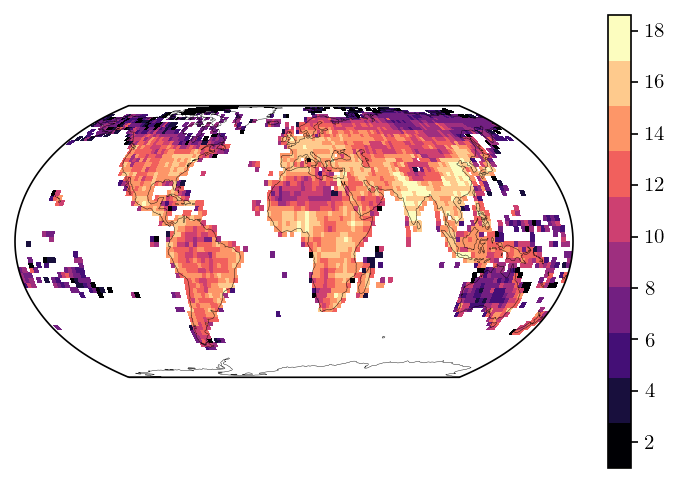

In [4]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines(lw=0.2)


shape = (len(ndf.LAT.unique()), len(ndf.LON.unique()))

n = np.log(np.array(ndf.population).reshape(shape))

n[n==0] = np.NaN

mesh=ax.pcolormesh(
    ndf.LON.unique(), 
    ndf.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('magma',10), vmin=1, 
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)

In [5]:
ndf.head()
ndf['diff_temp'] = np.NaN
ndf['diff_precip'] = np.NaN
ndf.loc[((ndf['knutson_temp']>1)) & ((ndf['updated_temp']<=1)| (pd.isna(ndf['updated_temp']))),'diff_temp'] = -1
ndf.loc[(ndf['knutson_temp']>1) & (ndf['updated_temp']>1),'diff_temp'] = 1
ndf.loc[((ndf['knutson_temp']<1) | (pd.isna(ndf['knutson_temp'])) ) & (ndf['updated_temp']>1),'diff_temp'] = 2


ndf.loc[(abs(ndf['knutson_precip']).isin([2,3])) & (~abs(ndf['updated_precip']).isin([2,3])),"diff_precip"] = -1
ndf.loc[(abs(ndf['knutson_precip']).isin([2,3])) & (abs(ndf['updated_precip']).isin([2,3])),"diff_precip"] = 1
ndf.loc[(~abs(ndf['knutson_precip']).isin([2,3])) & (abs(ndf['updated_precip']).isin([2,3])),"diff_precip"] = 2

ndf.head()

,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,knutson_precip,updated_precip,knutson_temp,updated_temp,population,diff_temp,diff_precip
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN


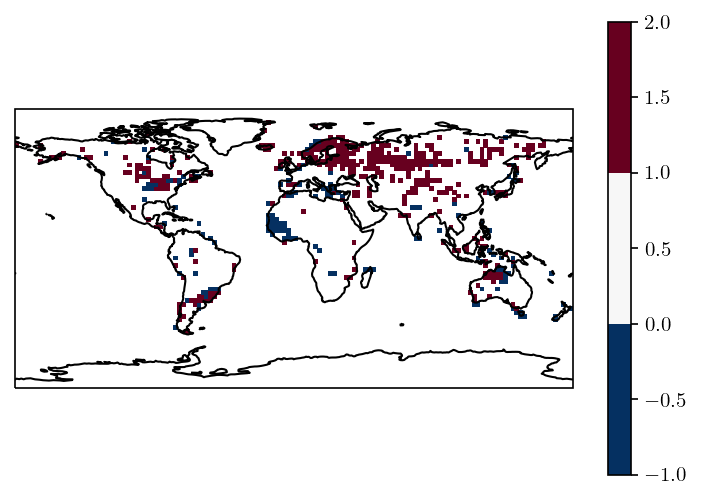

In [6]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()


shape = (len(ndf.LAT.unique()), len(ndf.LON.unique()))

n = np.array(ndf.diff_precip).reshape(shape)

mesh=ax.pcolormesh(
    ndf.LON.unique(), 
    ndf.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('RdBu_r',3), vmin=-1, vmax=2,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)

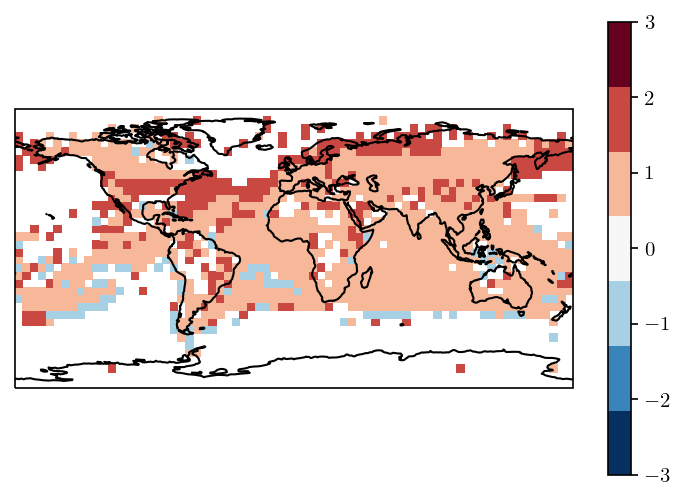

In [7]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()


shape = (len(ndf.LAT.unique()), len(ndf.LON.unique()))

n = np.array(ndf.diff_temp).reshape(shape)

mesh=ax.pcolormesh(
    ndf.LON.unique(), 
    ndf.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)

0
0 0
1
1 0
2
2 0
3
0 1
4
1 1
5
2 1


/home/max/software/geopenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


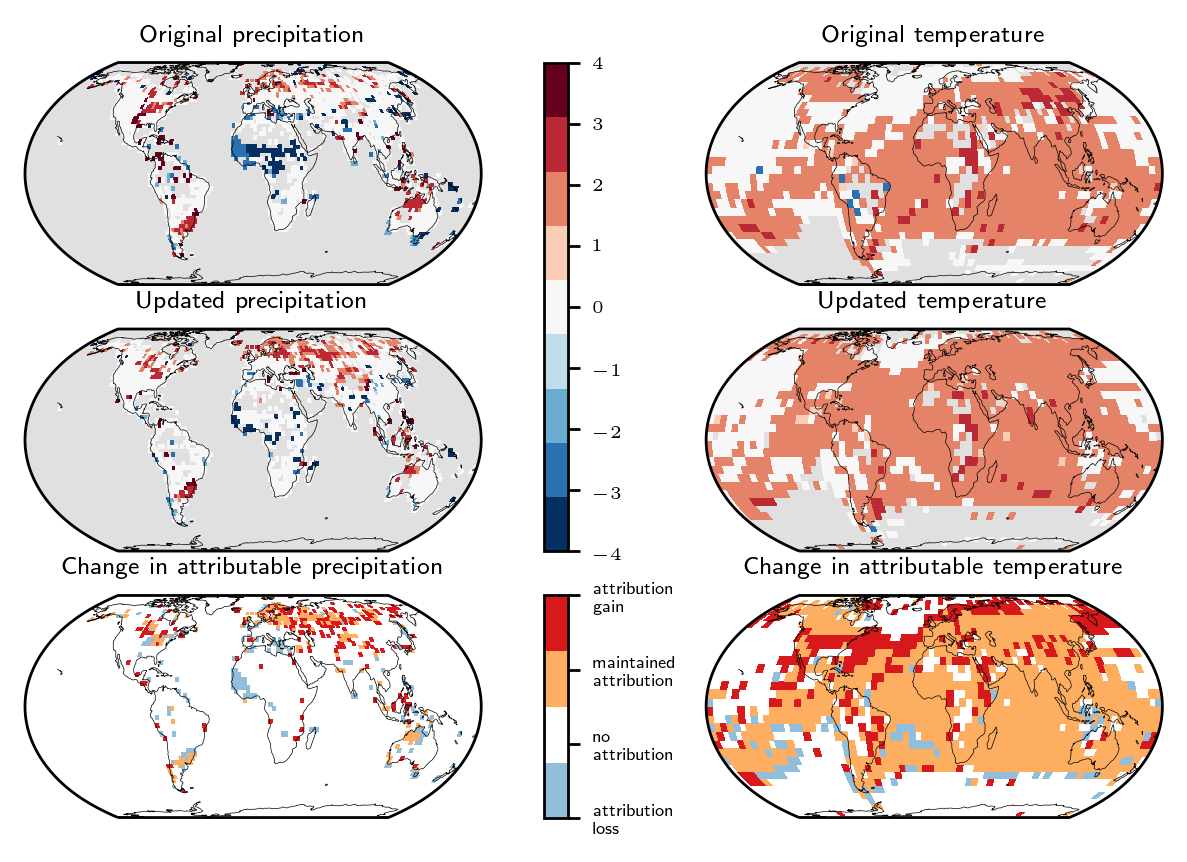

In [8]:
import matplotlib.gridspec as gridspec
import matplotlib as mpl

fig = plt.figure(constrained_layout=True, dpi=250)
gs = gridspec.GridSpec(ncols=4, nrows=3, figure=fig, width_ratios=[1,0.05,0.05,1],wspace=0.2)

for i, cname in enumerate(import_data):
    print(i)
    print(i%3,i//3)
    ax = fig.add_subplot(gs[i%3,i//3+i//3+i//3], projection=ccrs.EqualEarth())
    
    ax.set_title(cname[2],fontsize=7)
    
    ax.coastlines(lw=0.2)
    shape = (len(ndf.LAT.unique()), len(ndf.LON.unique()))
    
    n = np.array(ndf[cname[1]]).reshape(shape)
    
    if cname[0] is not None:
        bn = np.zeros((len(ndf.LAT.unique()), len(ndf.LON.unique())))
        bn+=1
        mesh = ax.pcolormesh(
            ndf.LON.unique(),#-degrees*0.5,
            ndf.LAT.unique(),#-degrees*0.5,
            bn,
            cmap = mpl.colors.ListedColormap(["#e0e0e0"]),
            transform=ccrs.PlateCarree(),
        )

        mesh_1=ax.pcolormesh(
            ndf.LON.unique(), 
            ndf.LAT.unique(), 
            n, 
            cmap=plt.cm.get_cmap('RdBu_r',9), vmin=-4, vmax=4,
            transform=ccrs.PlateCarree(),
        )
    else:
        mesh_2=ax.pcolormesh(
            ndf.LON.unique(), 
            ndf.LAT.unique(), 
            n, 
            cmap=mpl.colors.ListedColormap(['#91bfdb','white','#fdae61','#d7191c']),
            transform=ccrs.PlateCarree(),
        )
        
ax = fig.add_subplot(gs[:2,1])
ax.axis('off')
cbar = plt.colorbar(mesh_1,ax=ax, pad=-0.1, fraction=1)
cbar.set_ticks(np.linspace(-4,4,9))
cbar.ax.tick_params(labelsize=5)

ax = fig.add_subplot(gs[2,1])
ax.axis('off')
cbar = plt.colorbar(mesh_2,ax=ax, pad=-0.4, fraction=1)
cbar.set_ticks(np.arange(-1,3))
cbar.set_ticklabels(["attribution\nloss","no\nattribution","maintained\nattribution","attribution\ngain"])
cbar.ax.tick_params(labelsize=5)
    
#plt.savefig('../plots/attribution_changes.pdf',bbox_inches="tight")

In [9]:
np.linspace(-4,4,9)

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

In [10]:
ndf.to_csv('../data/2_blank_da_data.csv',index=False)